In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

### Import packages
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms, models
from PIL import Image
import os

In [3]:
def predict(image_path, model,device='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    eval_img = process_image(image_path)
    eval_img = eval_img.unsqueeze(0).to(device)
    logits = model.forward(eval_img)
    ps = F.softmax(logits, dim=1)
    return ps

In [9]:
from collections import OrderedDict
def load_base_model(device, classes):
    model = models.resnet152(pretrained=True)

    ## Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.layer3.parameters():
        param.requires_grad = False
        
    for param in model.layer4.parameters():
        param.requires_grad = False

    
    fc = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, len(classes))),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.fc = fc
    model.to(device)
    return model

def load_checkpoint(device, classes):
    model = load_base_model(device, classes)
    temp_model = torch.load('model_resnet_maxaccu_152_p99.pt', map_location=lambda storage, loc: storage)
    fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, len(temp_model['fc.fc2.weight']))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.fc = fc
    model.load_state_dict(torch.load('model_resnet152_p99.pt', map_location=lambda storage, loc: storage))
    return model

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def top_classes(img_path, model, device, classes):
    processed_image = process_image(img_path)
    img_result = predict(img_path, model, device)
    probs, idx = torch.topk(img_result, 10)
    probs,idx = probs.squeeze(), idx.squeeze()
    
    title = img_path
    img = Image.open(img_path)
    
    labels = []
    probabilities = []
    for i,prob in enumerate(probs):
        labels.append(classes[idx[i].item()])
        probabilities.append(prob.item())
    print(img_result.size())
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    ax1.set_title(title)
    ax1.imshow(img)
    ax1.axis('off')
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([x for x in labels])
    ax2.invert_yaxis()
    
    
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open( image )
    img.load()
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize
    ])
    img_tensor = preprocess(img)
    return img_tensor

def getClassesFromFiles():
    my_classes = []
    for filename in os.listdir("./url_files/"):
        if filename.find("_valid.txt") == -1 and filename.find(".txt") > 0:
            my_classes.append(filename.replace('.txt',''))
    my_classes = sorted(my_classes)
    return my_classes

torch.Size([1, 27])


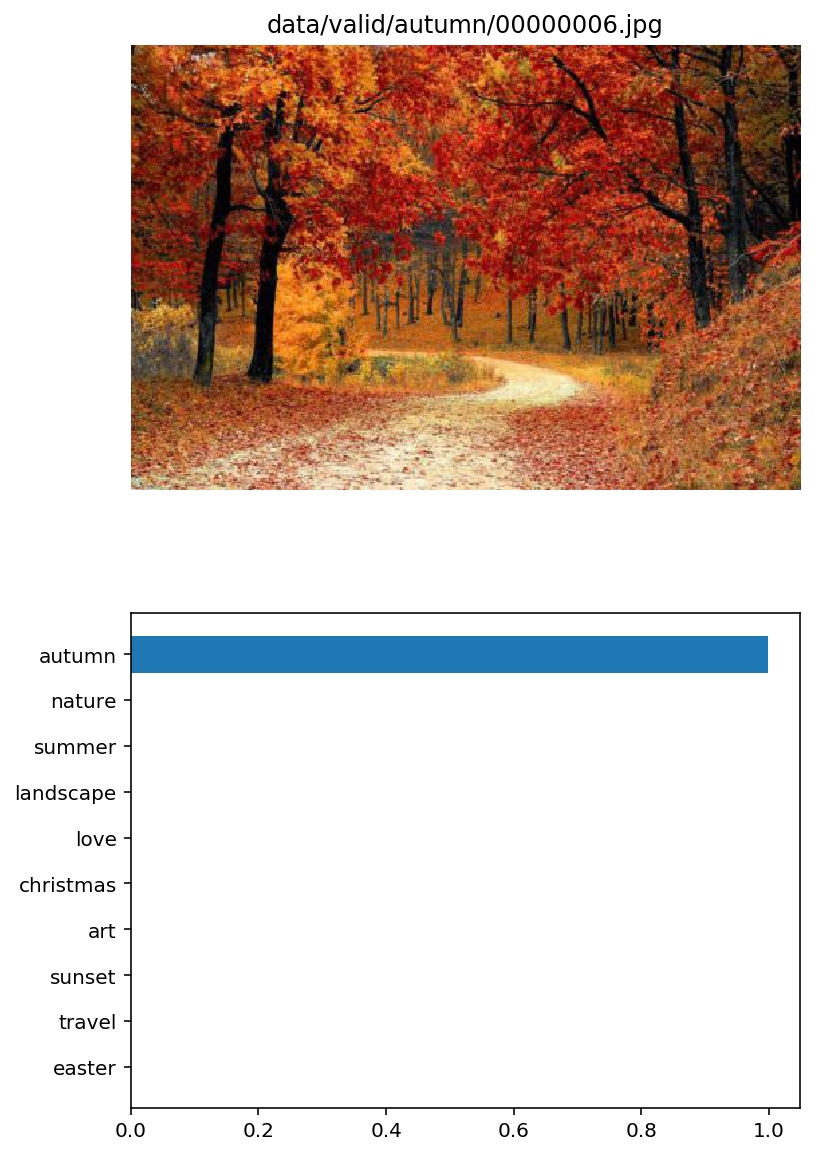

In [10]:
device_to = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = getClassesFromFiles()
top_classes('data/valid/autumn/00000006.jpg', load_checkpoint(device_to, class_names), device_to, class_names)

In [19]:
!wget https://images.pexels.com/photos/1633522/pexels-photo-1633522.jpeg
print(device_to)


--2019-01-12 18:19:36--  https://images.pexels.com/photos/1633522/pexels-photo-1633522.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.16.239.112, 104.16.242.112, 104.16.238.112, ...
Connecting to images.pexels.com (images.pexels.com)|104.16.239.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4566446 (4.4M) [image/jpeg]
Saving to: ‘pexels-photo-1633522.jpeg’

pexels-photo-163352 100%[===================>]   4.35M  2.77MB/s    in 1.6s    

2019-01-12 18:19:38 (2.77 MB/s) - ‘pexels-photo-1633522.jpeg’ saved [4566446/4566446]

cpu


In [20]:
!mv pexels-photo-1633522.jpeg running-dogs.jpeg

torch.Size([1, 27])


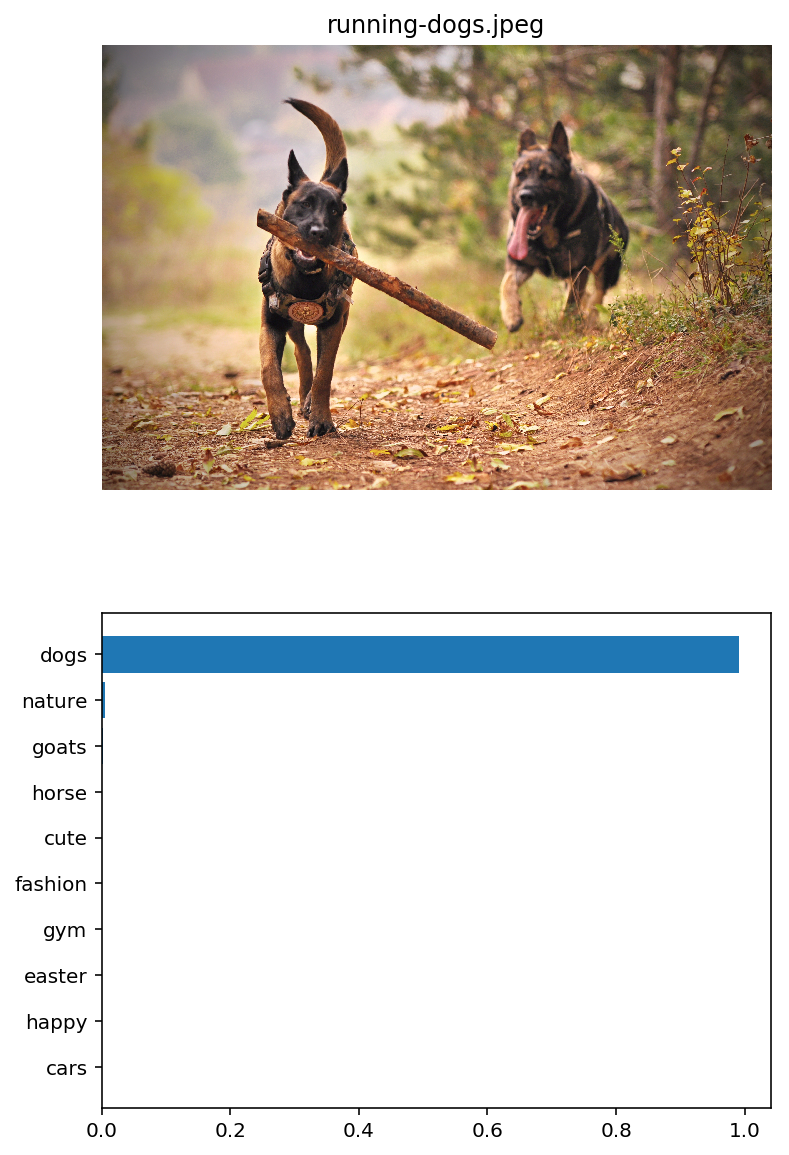

In [22]:
top_classes('running-dogs.jpeg', load_checkpoint(device_to, class_names), device_to, class_names)